# The Hackernews Scraper

## Importing Libraries

* Requests: To make http(s) requests
* BeautifulSoup4: To 
* PyMongo: To interact with mongodb database

In [1]:
import requests
from bs4 import BeautifulSoup
#from pymongo import MongoClient
from pathlib import Path
import json

## Phase 1: Extracting the MetaData of all posts from all pages specified by the User

First, let's create a function that returns the parsed html soup of a link given as parameter.

In [2]:
def link_to_soup(link):
    response = requests.get(link)
    if response.ok:
        return BeautifulSoup(response.text, 'html.parser')
    else:
        return False

Requesting to get the home page of TheHackerNews.com

<!DOCTYPE html>

<html dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<meta content="width=device-width,initial-scale=1.0" name="viewport"/>
<link as="style" crossorigin="anonymous" href="/css/roboto.css" rel="preload"/>
<link href="/css/roboto.css" rel="stylesheet"/>
<noscript><link href="/css/roboto.css" rel="stylesheet"/></noscript>
<link href="https://ajax.cloudflare.com" rel="dns-prefetch"/>
<link crossorigin="crossorigin" href="https://ajax.cloudflare.com" rel="preconnect"/>
<link href="https://pagead2.googlesyndication.com" rel="dns-prefetch"/>
<link crossorigin="crossorigin" href="https://pagead2.googlesyndication.com" rel="preconnect"/>
<link href="https://cdnjs.cloudflare.com/" rel="dns-prefetch"/>
<link crossorigin="crossorigin" href="https://cdnjs.cloudflare.com/" rel="preconnect"/>
<link href="https://storage.googleapis.com/" rel="dns-prefetch"/>
<link crossorigin="crossorigin" href="https://storage.googleapis.com/" rel="preconnect"/>
<link href="https://googleads.g.d
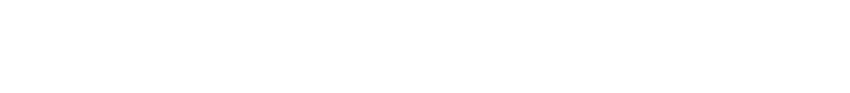
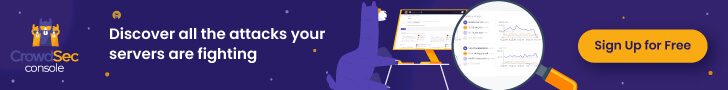

In [3]:
home_page_soup = link_to_soup('https://thehackernews.com/')
print(home_page_soup)

We are able to parse the html document as well. Let's ask the user, for how many pages, the data has to be extracted.

In [4]:
No_pages = int(input('How many pages to extract the data from? '))

How many pages to extract the data from? 10


We will parse the the rest of the pages and append all of the pages to the array 'pages'

In [5]:
pages = []
pages.append(home_page_soup)
No_pages -= 1
for i in range(No_pages):
    next_page_link = pages[i].find("a", class_="blog-pager-older-link-mobile")['href']
    pages.append(link_to_soup(next_page_link))
    

Now we have all the pages parsed to extract the data from. So, let's extract all the data.

In [6]:
posts_url_title_data = []
posts_url_others_data = []

for page in pages:
    posts_in_page = home_page_soup.find_all("a", class_='story-link')
    for post in posts_in_page:
        posts_url_title_data.append({
        "url" : post['href'],
        "title" : post.find("h2", class_='home-title').text
        })
        
        posts_url_others_data.append({
        "url" : post['href'],
        "desc" : post.find("div", class_='home-desc').text,
        "author" : post.find("span").text[1:len(post.find("span").text)-1],
        "imgSrc" : post.find("img")['data-src']
        })
    
print('URL of 1st post: ', posts_url_title_data[0]['url'])
print('Description of 1st post: ', posts_url_others_data[0]['desc'])
print('Author of the 1st post: ', posts_url_others_data[0]['author'])
print('Image source of the 1st post: ', posts_url_others_data[0]['imgSrc'])
print('Title of the 1st post: ', posts_url_title_data[0]['title'])

URL of 1st post:  https://thehackernews.com/2022/10/experts-warn-of-new-ratmilad-android.html
Description of 1st post:   A novel Android malware called RatMilad has been observed targeting a Middle Eastern enterprise mobile device by concealing itself as a VPN and phone number spoofing app.  The mobile trojan functions as advanced spyware with capabilities that receives and executes commands to collect and exfiltrate a wide variety of data from the infected mobile endpoint, Zimperium  said  in a report shared with The Hacker News.  Evidence gathered by the mobile security company shows that the malicious app is distributed through links on social media and communication tools like Telegram, tricking unsuspecting users into sideloading the app and granting it extensive permissions.   The idea behind embedding the malware within a fake VPN and phone number spoofing service is also clever in that the app claims to enable users to verify social media accounts via phone, a technique popular

Metadata of all posts from all pages is extracted. Phase 1 completed!

## Phase 2: Store the data

### Phase 2a:  Store the data in a MongoDb database

We'll store the data in two documents having:
1. Url and title of the blog
2. Url and Desription, Image, Author)

First, Let's connect to the mongodb server by asking the user MongoDbURI

In [ ]:
mongoDbURI = input('Enter the mongoDbURI: ')
client = MongoClient(mongoDbURI) # for users running mongo server on local machine: 'mongodb://localhost:27017/'

In [ ]:
# Getting the database
db = client['hackernews']

# Getting the collections
urlTitle = db['url-title']
urlOthers = db['url-others']

Connection done, now we'll insert the data.

In [ ]:
result1 = urlTitle.insert_many(posts_url_title_data)
result2 = urlOthers.insert_many(posts_url_others_data)

Let's check if the values were inserted properly.

In [ ]:
print(result1.inserted_ids[:5])
print(result2.inserted_ids[:5])

We can see the Object Ids of the inserted documents, that means the documents were inserted to the database successfully.

Phase 2a completed!

### Phase 2b: Save the data as JSON

We will save the data as a single JSON file, merging `posts_url_title_data` with `posts_url_others_data`.

In [ ]:
# Merge data into a single dictionary
n = len(posts_url_title_data)
posts_url_data = [ dict(posts_url_title_data[0], **posts_url_others_data[0]) for i in range(n) ]

In [ ]:
output_location = input("Enter the location to save the JSON to: ")
output_path = Path(output_location)

# Create any necessary parent directories
if not output_path.parent.exists():
    print("Directory {} does not exist, creating.".format(output_path.parent))
    output_path.parent.mkdir(parents=True)

# Save JSON
with open(output_path, "w") as output_file:
    print("Saving to {}.".format(output_path))
    output_file.write(json.dumps(posts_url_data))

print("Done!")

### Phase 2c: Save data in MySQL using pymysql ORM

In [7]:
## connect to mysql db
import pymysql
def mysqlconnect():
    # To connect MySQL database
    conn = pymysql.connect(
        host='localhost',
        user='root', 
        password = "Password1!",
        db='scraper',
        )
    return conn

In [8]:
conn_obj = mysqlconnect()

In [9]:
conn_cursor = conn_obj.cursor()

### SQL relation model setup queries

In [10]:
# DB creation
sql_db_create = "create database if not exists scraper;"

# Use DB created
sql_use_db = "use scraper;"

# create table "urlTitle" to store [urlLink, urlTitle]
sql_create_urlTitle_table = "create table if not exists urltitle(\
  url_title_id int auto_increment primary key,\
  url_link text not null,\
  url_title text not null)"

# create table "urlotherInfo" to store [urlLink, urlTitle, urlAuthor, urlImgSrc]
sql_create_urlOtherInfo_table = "create table if not exists urlotherinfo(\
  id int auto_increment primary key,\
  url_link text not null,\
  url_description text not null,\
  author text not null,\
  imgsrc text not null)"


### SQL Queries execution

In [11]:
conn_cursor.execute(sql_db_create)

1

In [12]:
conn_cursor.execute("use scraper")
output=conn_cursor.fetchall()
print(output)

()


In [13]:
conn_cursor.execute(sql_create_urlTitle_table)

0

In [14]:
conn_cursor.execute(sql_create_urlOtherInfo_table)

0

In [15]:
conn_cursor.execute("show tables")
output = conn_cursor.fetchall()
print(output)

(('urlotherinfo',), ('urltitle',))


### Save the data in DB tables 

In [16]:
sql_insert_urlTitle = "insert into urltitle(url_link, url_title) values (%s, %s)"
sql_insert_urlOtherInfo = "insert into urlotherinfo(url_link, url_description, author, imgSrc) values (%s, %s, %s, %s)"
for url_title, url_other in zip(posts_url_title_data, posts_url_others_data):
    conn_cursor.execute(sql_insert_urlTitle, (url_title["url"], url_title["title"]))
    output = conn_cursor.fetchall()
    conn_cursor.execute(sql_insert_urlOtherInfo, (url_other["url"], url_other["desc"], url_other["author"], url_other["imgSrc"]))
    

In [17]:
conn_cursor.execute("select * from urltitle")
output=conn_cursor.fetchall()
print(output)

((1, 'http://localhost', 'sample title'), (2, 'http://localhost', 'sample title'), (3, 'https://thehackernews.com/2022/10/experts-warn-of-new-ratmilad-android.html', 'Experts Warn of New RatMilad Android Spyware Targeting Enterprise Devices'), (4, 'https://thehackernews.com/2022/10/telstra-telecom-suffers-data-breach.html', 'Telstra Telecom Suffers Data Breach Potentially Exposing Employee Information'), (5, 'https://thehackernews.com/2022/10/fbi-cisa-and-nsa-reveal-how-hackers.html', 'FBI, CISA, and NSA Reveal How Hackers Targeted a Defense Industrial Base Organization'), (6, 'https://thehackernews.com/2022/10/want-more-secure-software-start.html', 'Want More Secure Software? Start Recognizing Security-Skilled Developers'), (7, 'https://thehackernews.com/2022/10/canadian-netwalker-ransomware-affiliate.html', 'Canadian Netwalker Ransomware Affiliate Sentenced to 20 Years in U.S. Prison'), (8, 'https://thehackernews.com/2022/10/mitigation-for-exchange-zero-days.html', 'Mitigation for Ex

In [18]:
conn_cursor.close()